In [38]:
import glob
import os
import sys
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.stats as stats
from sklearn import linear_model

sys.path.append("../../../code/ndsvae/")
import ndsvae as ndsv

sys.path.append("..")
import util
import plot

%matplotlib inline

In [3]:
ds = ndsv.Dataset.from_file("../run/main/pmfm_avg/dataset.npz")
nsub, nreg, nobs, nt = ds.y.shape
run0 = util.select_run("pmfm_avg", "AN", "ns_2_mreg_2_msub_1_nf_32", [0,1])
epss = np.logspace(-2,0,5)

## Plotting

In [49]:
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.sans-serif'] = "Arial"

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Pearson's correlation

In [27]:
def get_fcfits(ds, variant, seeds, runs):
    BLOWUP_THRESHOLD = 10.
    params = "ns_2_mreg_2_msub_1_nf_32"
    model = "modelAN"
    
    nsub, nreg, _, nt = ds.y.shape
    triu = np.triu_indices(nreg, k=1)
    fc1s = [np.corrcoef(ds.y[i,:,0,:]) for i in range(nsub)]
    
    if seeds is None:
        filenames = [os.path.join(f"{variant}/{model}/{params}/run{run:02d}/simulations.npz") for run in runs]
    else:
        filenames = [os.path.join(f"{variant}_{seed:02d}/{model}/{params}/run{run:02d}/simulations.npz")
                     for seed in seeds for run in runs]
    
    pc = []
    for filename in filenames:
        sims = ndsv.GeneratedData.from_file(filename)
        nsamples = sims.y.shape[0]
        
        for j in range(nsamples):
            fc2s = [np.corrcoef(sims.y[j,i,:,0,-nt:]) for i in range(nsub)]
            pc.append([np.corrcoef(fc1[triu], fc2[triu])[1,0] for fc1, fc2 in zip(fc1s, fc2s)])            
    pc = np.array(pc).T
    return pc
    
  
pc_zero = get_fcfits(ds, "../run/main/pmfm_avg", None, [run0])
pc_logw = get_fcfits(ds, "../run/conn/pmfm_avg-logw", None, [0])    
pc_eps  = [get_fcfits(ds, f"../run/conn/pmfm_avg-eps_{eps:5.3f}", [0,1,2,3], [0]) for eps in epss]

In [28]:
# Normalize
pcn_zero = pc_zero / np.mean(pc_zero, axis=1)[:,None]
pcn_logw = pc_logw / np.mean(pc_zero, axis=1)[:,None]
pcn_eps = [pc/np.mean(pc_zero, axis=1)[:,None] for pc in pc_eps]

## Parameter correlations

In [52]:
def get_rhos(ptru, pest, nsamples):
    """
    ptru ... Ground truth, shape (n,)
    pest ... Estimated parameters (Gaussians, mu and std in last dimension), shape (n, m, 2)
    n = number of parameters, m = dimensionality of the estimated parameter space
    
    Returns array of shape (nsamples) with Spearman's rho
    """
    
    # Find projection matrix from means
    linreg = linear_model.LinearRegression().fit(pest[:,:,0], ptru)
    
    rhos = np.zeros(nsamples)
    for i in range(nsamples):
        pest_samples = np.random.normal(pest[:,:,0], pest[:,:,1])
        pest_samples_projected = linreg.predict(pest_samples)
                        
        rhos[i] = stats.spearmanr(ptru, pest_samples_projected)[0]
                
    return rhos  


def get_rhos_noise(ds, variant, seeds, runs, nsamples=100):
    params = "ns_2_mreg_2_msub_1_nf_32"
    model = "modelAN"
    
    nsub, nreg, _, nt = ds.y.shape
    
    ptru = ds.thetareg[:,:,0].ravel()
    
    if seeds is None:
        filenames = [os.path.join(f"{variant}/{model}/{params}/run{run:02d}/parameters.npz") for run in runs]
    else:
        filenames = [os.path.join(f"{variant}_{seed:02d}/{model}/{params}/run{run:02d}/parameters.npz")
                     for seed in seeds for run in runs]
    
    rhos = []
    for filename in filenames:
        params = ndsv.Params.from_file(filename)
        pest = params.thetareg.reshape((nsub*nreg,-1,2))
        rhos.extend(get_rhos(ptru, pest, nsamples))
    return np.array(rhos)


def get_rhos_g(ds, variant, seeds, runs, nsamples=100):
    params = "ns_2_mreg_2_msub_1_nf_32"
    model = "modelAN"
    
    nsub, nreg, _, nt = ds.y.shape
    
    ptru = ds.thetasub[:,0]
    
    if seeds is None:
        filenames = [os.path.join(f"{variant}/{model}/{params}/run{run:02d}/parameters.npz") for run in runs]
    else:
        filenames = [os.path.join(f"{variant}_{seed:02d}/{model}/{params}/run{run:02d}/parameters.npz")
                     for seed in seeds for run in runs]
    
    rhos = []
    for filename in filenames:
        params = ndsv.Params.from_file(filename)
        pest = params.thetasub
        rhos.extend(get_rhos(ptru, pest, nsamples))
    return np.array(rhos)

        
rhon_zero = get_rhos_noise(ds, "../run/main/pmfm_avg", None, [run0])
rhon_logw = get_rhos_noise(ds, "../run/conn/pmfm_avg-logw", None, [0])    
rhon_eps  = [get_rhos_noise(ds, f"../run/conn/pmfm_avg-eps_{eps:5.3f}", [0,1,2,3], [0]) for eps in epss]

rhog_zero = get_rhos_g(ds, "../run/main/pmfm_avg", None, [run0])
rhog_logw = get_rhos_g(ds, "../run/conn/pmfm_avg-logw", None, [0])    
rhog_eps  = [get_rhos_g(ds, f"../run/conn/pmfm_avg-eps_{eps:5.3f}", [0,1,2,3], [0]) for eps in epss]

## Regional features

In [10]:
def wdist(x, y):
    assert x.shape[0] == 1
    nsamples, npoints, nt = y.shape
    
    bins = np.linspace(-2, 2, 20+1)
    centers = (bins[1:] + bins[:-1])/2.
    dist = np.zeros((nsamples, npoints))
    
    for j in range(npoints):
        px = np.histogram(x[0,j], bins, density=True)[0]
        px /= np.sum(px)    
        
        for i in range(nsamples):
            py = np.histogram(y[i,j], bins, density=True)[0]
            py /= np.sum(py)
            dist[i,j] = stats.wasserstein_distance(centers, centers, px, py)
    return dist


def get_wasserstein(ds, variant, seeds, runs):
    params = "ns_2_mreg_2_msub_1_nf_32"
    model = "modelAN"
    
    nsub, nreg, _, nt = ds.y.shape
    
    if seeds is None:
        filenames = [os.path.join(f"{variant}/{model}/{params}/run{run:02d}/simulations.npz") for run in runs]
    else:
        filenames = [os.path.join(f"{variant}_{seed:02d}/{model}/{params}/run{run:02d}/simulations.npz")
                     for seed in seeds for run in runs]
    
    y1 = ds.y[:,:,0,-nt:].reshape((1, nsub*nreg, nt))
    
    dists = []
    for filename in filenames:
        sims = ndsv.GeneratedData.from_file(filename)
        nsamples = sims.y.shape[0]
        y2 = sims.y[:,:,:,0,-nt:].reshape((nsamples, nsub*nreg, nt))
        dists.extend(wdist(y1, y2).ravel())
        
    return np.array(dists)

dists_zero = get_wasserstein(ds, "../run/main/pmfm_avg", None, [run0])
dists_logw = get_wasserstein(ds, "../run/conn/pmfm_avg-logw", None, [0])    
dists_eps  = [get_wasserstein(ds, f"../run/conn/pmfm_avg-eps_{eps:5.3f}", [0,1,2,3], [0]) for eps in epss]

In [21]:
def get_mode_limits(y, separating_mass, npoints):
    npoints = 201
    
    lims = np.min(y), np.max(y)
    x = np.linspace(lims[0], lims[1], npoints)    
    pdf, _ = np.histogram(y, bins=x, density=True)
    pdf /= np.sum(pdf)
    cdf = np.cumsum(pdf)

    def mass_interval(cdf, i):
        try:
            return (i, np.where(cdf - cdf[i] >= separating_mass)[0][0])
        except IndexError:
            return None

    mass_intervals = [mass_interval(cdf, i) for i in range(npoints)]
    dists = np.array([(mi[1] - mi[0]) if mi is not None else 0 for mi in mass_intervals])
    
    # To ignore the boundaries
    dists[:-1][cdf < separating_mass] = 0.
    
    ind = np.argmax(dists)
    i1, i2 = mass_intervals[ind]
    
    return x[i1], x[i2]
    
MODE_LIMITS = get_mode_limits(ds.y.ravel(), 0.1, 201)

In [25]:
def nswitches(y, axis):
    """Calculates number of switches along the axis"""        
    y = np.moveaxis(y, [axis] + list(np.r_[:axis]), [0] + list(np.r_[1:axis+1]))
    
    state = np.zeros_like(y, dtype=int)
    state[y < MODE_LIMITS[0]] = -1
    state[y > MODE_LIMITS[1]] = 1
    
    nt = y.shape[0]
    
    state[0][state[0] == 0] = 1
    for i in range(1,nt):
        mask = (state[i] == 0)
        state[i][mask] = state[i-1][mask]
      
    return np.log(np.sum((state[1:] - state[:-1]) != 0, axis=0) + 1)

def get_nswitches(ds, variant, seeds, runs):
    params = "ns_2_mreg_2_msub_1_nf_32"
    model = "modelAN"
    
    nsub, nreg, _, nt = ds.y.shape
    
    if seeds is None:
        filenames = [os.path.join(f"{variant}/{model}/{params}/run{run:02d}/simulations.npz") for run in runs]
    else:
        filenames = [os.path.join(f"{variant}_{seed:02d}/{model}/{params}/run{run:02d}/simulations.npz")
                     for seed in seeds for run in runs]
    
    y1 = ds.y[:,:,0,-nt:].reshape((1, nsub*nreg, nt))
    n1 = nswitches(y1, axis=-1)
    
    diffs = []
    for filename in filenames:
        sims = ndsv.GeneratedData.from_file(filename)
        nsamples = sims.y.shape[0]
        y2 = sims.y[:,:,:,0,-nt:].reshape((nsamples, nsub*nreg, nt))
        n2 = nswitches(y2, axis=-1)
        diffs.extend(np.abs(n1 - n2).ravel())
        
    return np.array(diffs)

nswitches_zero = get_nswitches(ds, "../run/main/pmfm_avg", None, [run0])
nswitches_logw = get_nswitches(ds, "../run/conn/pmfm_avg-logw", None, [0])    
nswitches_eps  = [get_nswitches(ds, f"../run/conn/pmfm_avg-eps_{eps:5.3f}", [0,1,2,3], [0]) for eps in epss]

## Plot

In [68]:
def plot_ci(pos, x, q, color='k', ls='-', zorder=None):
    plt.plot([pos,pos], np.nanpercentile(x, q), lw=1, color=color, ls=ls, zorder=zorder)
    plt.scatter(pos, np.nanmedian(x), color=color, s=5, zorder=zorder)    

    
def plot_comparison(ax, x_zero, x_logw, x_eps, epss, title=None, ylabel=None):
    
    poss = [0.001, 0.0032] + list(epss)
    plot_ci(poss[0], x_logw.ravel(), [5,95], color='b')
    plot_ci(poss[1], x_zero.ravel(), [5,95], color='r')
    
    for eps, x in zip(epss, x_eps):
        plot_ci(eps, x.ravel(), [5,95])

    labels = ["Log conn", "True conn"] + [f"{eps:0.3f}" for eps in epss]
    
    plt.xscale('log')
    plt.xlabel("         Perturbation", labelpad=-10)
    plt.minorticks_off()
    plt.xticks(poss, labels)
    
    for i, t in enumerate(ax.get_xticklabels()):
        t.set_rotation(90)
    # plt.grid()
    
    if title is not None:
        plt.title(title)
    if ylabel is not None:
        plt.ylabel(ylabel)    

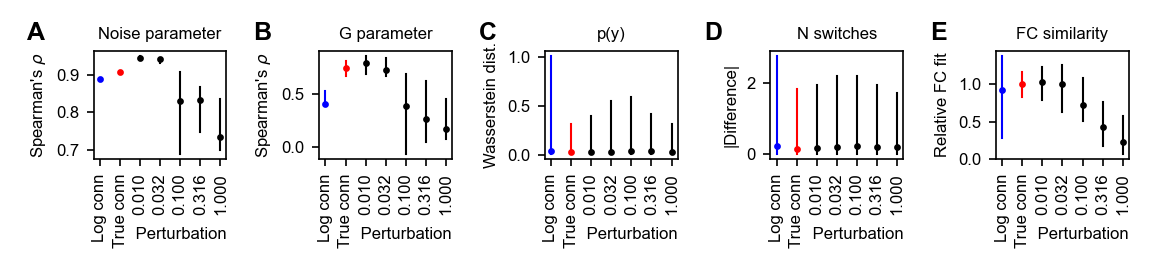

In [69]:
fig = plt.figure(figsize=(7.5, 1.6), dpi=150)
gs = gridspec.GridSpec(1, 5, wspace=0.7, left=0.07, right=0.99, bottom=0.4, top=0.85)

ax0 = plt.subplot(gs[0])
plot_comparison(ax0, rhon_zero, rhon_logw, rhon_eps, epss, title="Noise parameter", 
                ylabel=r"Spearman's $\rho$")

ax1 = plt.subplot(gs[1])
plot_comparison(ax1, rhog_zero, rhog_logw, rhog_eps, epss, title="G parameter",
                ylabel=r"Spearman's $\rho$")

ax2 = plt.subplot(gs[2])
plot_comparison(ax2, dists_zero, dists_logw, dists_eps, epss, title="p(y)",
                ylabel="Wasserstein dist.")

ax3 = plt.subplot(gs[3])
plot_comparison(ax3, nswitches_zero, nswitches_logw, nswitches_eps, epss, 
                title="N switches", ylabel="|Difference|")

ax4 = plt.subplot(gs[4])
plot_comparison(ax4, pcn_zero, pcn_logw, pcn_eps, epss, ylabel="Relative FC fit",
                title="FC similarity")

plot.add_panel_letters(fig, fontsize=12, xpos=-0.5, ypos=1.1)
bg = plot.Background(visible=False)
plt.savefig("./img/Fig_ConnPerturbation.pdf")